# CPC Speech usage examples

## Extract speech embeddings

In [13]:
import sys
sys.path.append('../cpcspeech/src/cpcspeech')
import cpcspeech
import h5py
import numpy as np
from sklearn.manifold import TSNE

In [2]:
! ls 

Contrastive_predictive_coding-WS.ipynb
Contrastive_predictive_coding_package_test_WS.ipynb
Contrastive_predictive_coding_package_test_WS_spk.ipynb


In [3]:
data_path = '/home/giovanni.maffei/datasets/librispeech/processed/data/librispeech_valid.hdf5'
sample_data = h5py.File(data_path, 'r')
seq_len = 20480
X = np.array([sample_data[k][:seq_len] for k in list(sample_data.keys())])
X = X[:,np.newaxis,:]

In [8]:
model_path = '../trained_models/cpc_test_model_2020-10-06-11:04:37'
cpc = cpcspeech.CPC_speech()
cpc.load_pretrained_model(model_path)

In [ ]:
speech_emb = cpc.transform(X)
# spk_lbl = 

In [ ]:
tsne_spk_emb = TSNE(n_components=2).fit_transform(speech_emb)
plt.scatter(tsne_spk_emb[:,0],tsne_spk_emb[:,1],c=spk_lbl)

## Preprocess dataset

In [ ]:
import sys
sys.path.append('cpc_speech/src/cpc_speech')
from data import LibriSpeech100_preprocessing

In [ ]:
# data_path = '/home/giovanni.maffei/datasets/librispeech/LibriSpeech/train-clean-100/'
data_path = '../../datasets/libri_speech/LibriSpeech/train-clean-100/'
split_path = 'data/labels_split/'
processed_data_path = 'data/processed/'
seq_len = 20480

train_file_list_path = split_path+'train_split.txt'
valid_file_list_path = split_path+'valid_split.txt'
# test_file_list_path  = '/home/giovanni.maffei/datasets/librispeech/oord_label_split/test_split.txt'

train_output_path = processed_data_path+'librispeech_train.hdf5'
valid_output_path = processed_data_path+'librispeech_valid.hdf5'
# test_output_path  = processed_data_path+'librispeech_test.hdf5'

In [ ]:
LibriSpeech100_preprocessing(train_file_list_path, data_path, train_output_path, seq_len)
LibriSpeech100_preprocessing(valid_file_list_path, data_path, valid_output_path, seq_len)

## CPC training

In [14]:
import sys
sys.path.append('../cpcspeech/src/cpcspeech')
import cpcspeech

In [15]:
cpc = cpcspeech.CPC_speech(gpu=True)

In [16]:
train_path = '/home/giovanni.maffei/datasets/librispeech/processed/data/librispeech_train.hdf5'
valid_path = '/home/giovanni.maffei/datasets/librispeech/processed/data/librispeech_valid.hdf5'
cpc.load_train_data(train_path, valid_path)

In [14]:
cpc.train(100,plot=True)

In [7]:
save_model_folder = 'trained_models/'
cpc.save_model(save_model_folder)

## Speaker classification with CPC embeddings

In [1]:
import sys
sys.path.append('../cpcspeech/src/cpcspeech')
from models import MLP#, CPC
from data import LibriSpeech100_dataset_spk_class
from train import Spk_Training
import cpcspeech
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# device_type = 'cpu'
device_type = 'cuda'
device = torch.device(device_type)

### load dataset

In [3]:
processed_data_path = '/home/giovanni.maffei/datasets/librispeech/processed/data/'

train_path = processed_data_path+'librispeech_train.hdf5'
valid_path = processed_data_path+'librispeech_valid.hdf5'
test_path  = processed_data_path+'librispeech_test.hdf5'

In [4]:
# train_path = 'data/processed/librispeech_train.hdf5'
# train_path = 'data/processed/librispeech_valid.hdf5'

In [5]:
seq_len = 20480
batch_size = 64

train_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
train_spk_dataloader = DataLoader(train_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

valid_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
valid_spk_dataloader = DataLoader(valid_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

test_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
test_spk_dataloader = DataLoader(valid_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

### load CPC model

In [6]:
model_path = '../trained_models/cpc_test_model_2020-10-06-11:04:37'

In [7]:
cpc = cpcspeech.CPC_speech(gpu=True)
cpc.load_pretrained_model(model_path)
cpc.freeze()
cpc_model = cpc.cpc_model

In [8]:
# seq_len = 20480
# comp_rate = 160
# n_timesteps = 12

# cpc_model = CPC(n_timesteps, seq_len).to(device)
# cpc_model.load_state_dict(torch.load('workstation/contrastive_predictive_coding/trained_models/cpc_test_model_2020-10-06-11-04-37', map_location=device))

# for param in cpc_model.parameters():
#     param.requires_grad = False

### initialize MLP speaker model

In [9]:
n_speakers = len(train_spk_data.unique_spk_ids)
emb_size = 256
inner_size = 512
spk_classifier = MLP(emb_size, inner_size, n_speakers).to(device)

### train

In [10]:
train_params = [p for p in spk_classifier.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params, lr=0.0002, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
loss = F.nll_loss

-- epoch 0 --
train loss: 4.002369842194675
valid loss: 2.558095411668744
best valid loss: 2.558095411668744
train accuracy: 0.22291666666666668
valid accuracy: 0.47351973684210524


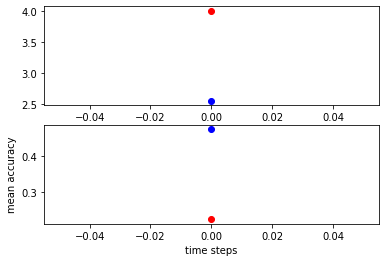

-- epoch 1 --
train loss: 2.0812939426355195
valid loss: 1.614558978666339
best valid loss: 1.614558978666339
train accuracy: 0.5760416666666667
valid accuracy: 0.6849780701754385


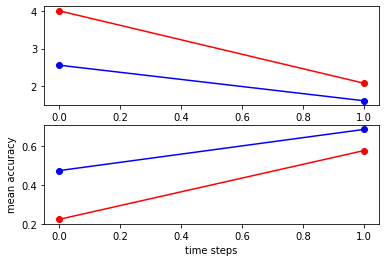

-- epoch 2 --
train loss: 1.4342259440505714
valid loss: 1.1871969133092646
best valid loss: 1.1871969133092646
train accuracy: 0.7244517543859649
valid accuracy: 0.7791118421052632


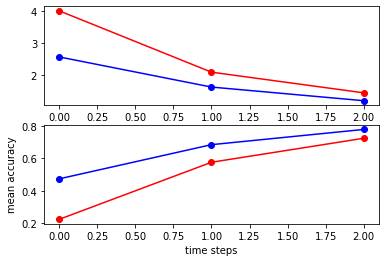

-- epoch 3 --
train loss: 1.1012195530690645
valid loss: 0.9389458108366582
best valid loss: 0.9389458108366582
train accuracy: 0.7930372807017544
valid accuracy: 0.8268640350877193


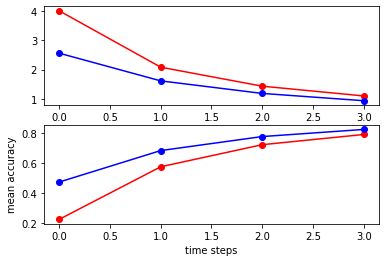

-- epoch 4 --
train loss: 0.8997197400059617
valid loss: 0.7733480974247581
best valid loss: 0.7733480974247581
train accuracy: 0.8336074561403509
valid accuracy: 0.8600877192982456


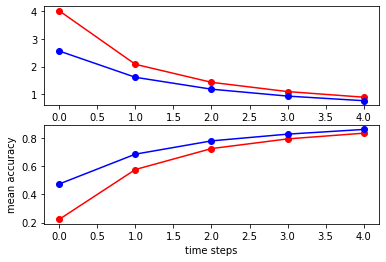

-- epoch 5 --
train loss: 0.7578886223466773
valid loss: 0.6634759775379248
best valid loss: 0.6634759775379248
train accuracy: 0.8597587719298245
valid accuracy: 0.8810307017543859


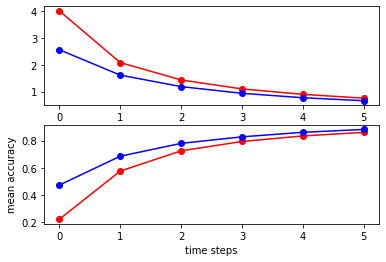

-- epoch 6 --
train loss: 0.6613562761691578
valid loss: 0.5804723543033266
best valid loss: 0.5804723543033266
train accuracy: 0.8767543859649123
valid accuracy: 0.8946271929824562


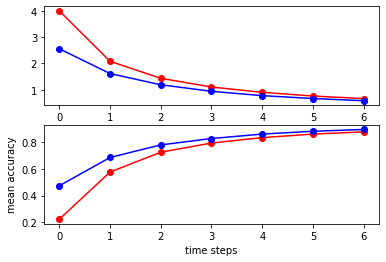

-- epoch 7 --
train loss: 0.5972908266803675
valid loss: 0.516726651735473
best valid loss: 0.516726651735473
train accuracy: 0.8827850877192982
valid accuracy: 0.9043311403508771


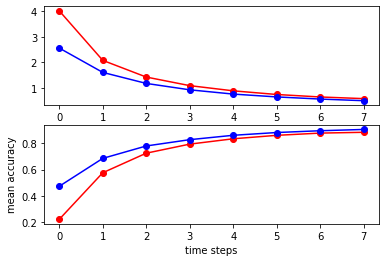

-- epoch 8 --
train loss: 0.5313267399344528
valid loss: 0.46040854589980945
best valid loss: 0.46040854589980945
train accuracy: 0.9007675438596491
valid accuracy: 0.9161184210526315


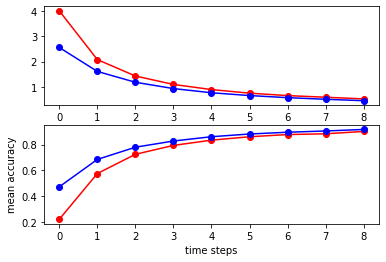

-- epoch 9 --
train loss: 0.4831762227050045
valid loss: 0.43281388680140176
best valid loss: 0.43281388680140176
train accuracy: 0.9084429824561403
valid accuracy: 0.9190241228070175


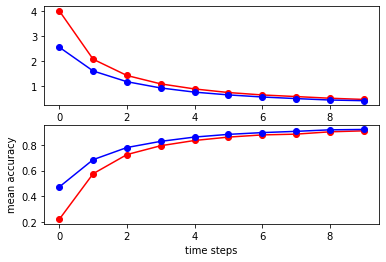

-- epoch 10 --
train loss: 0.4503886648437433
valid loss: 0.40647974265249154
best valid loss: 0.40647974265249154
train accuracy: 0.9129934210526316
valid accuracy: 0.921765350877193


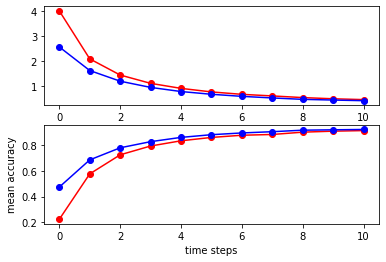

-- epoch 11 --
train loss: 0.4180241792871241
valid loss: 0.37204658242694116
best valid loss: 0.37204658242694116
train accuracy: 0.9175986842105263
valid accuracy: 0.9267543859649123


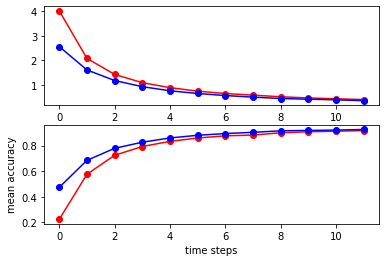

-- epoch 12 --
train loss: 0.39922676081197306
valid loss: 0.35100852407907185
best valid loss: 0.35100852407907185
train accuracy: 0.9196820175438597
valid accuracy: 0.9319078947368421


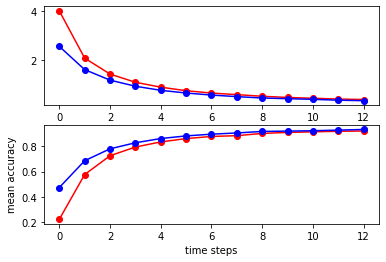

-- epoch 13 --
train loss: 0.3742446210823561
valid loss: 0.33966388294571326
best valid loss: 0.33966388294571326
train accuracy: 0.9265350877192983
valid accuracy: 0.9356359649122807


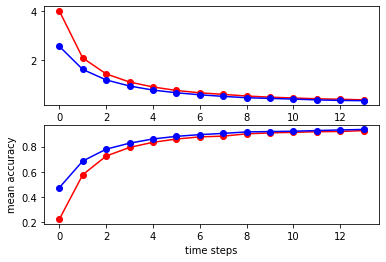

-- epoch 14 --
train loss: 0.3549949496461634
valid loss: 0.31991466048516726
best valid loss: 0.31991466048516726
train accuracy: 0.9274671052631579
valid accuracy: 0.9372807017543859


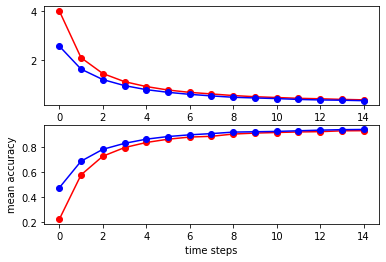

-- epoch 15 --
train loss: 0.3346668747433445
valid loss: 0.29856090838449045
best valid loss: 0.29856090838449045
train accuracy: 0.931688596491228
valid accuracy: 0.9412828947368421


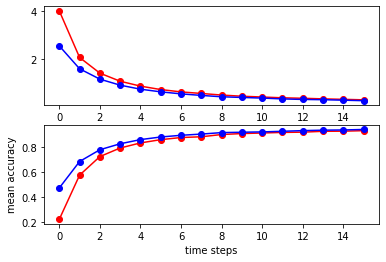

-- epoch 16 --
train loss: 0.3265057593061213
valid loss: 0.28980854007235746
best valid loss: 0.28980854007235746
train accuracy: 0.9323464912280702
valid accuracy: 0.9419407894736842


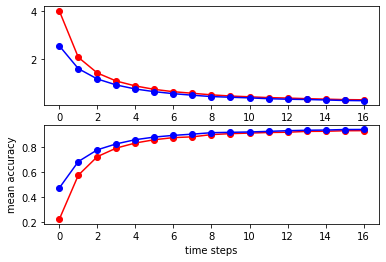

-- epoch 17 --
train loss: 0.31021301077123276
valid loss: 0.2728098388826638
best valid loss: 0.2728098388826638
train accuracy: 0.9328947368421052
valid accuracy: 0.946655701754386


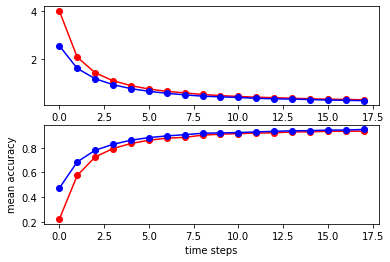

-- epoch 18 --
train loss: 0.3009687737937559
valid loss: 0.26704578148691277
best valid loss: 0.26704578148691277
train accuracy: 0.9375
valid accuracy: 0.9459429824561404


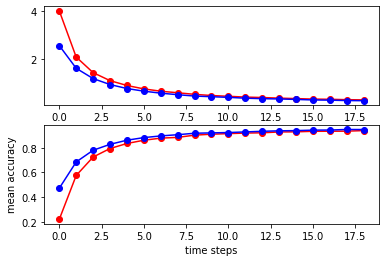

-- epoch 19 --
train loss: 0.2864955537151872
valid loss: 0.25094281931718193
best valid loss: 0.25094281931718193
train accuracy: 0.9398574561403509
valid accuracy: 0.9503289473684211


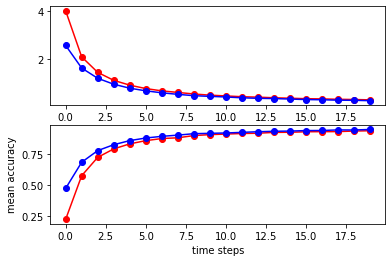

In [11]:
n_epochs = 20
spk_training = Spk_Training(cpc_model, spk_classifier, loss, optimizer, device)
spk_training.train(train_spk_dataloader, valid_spk_dataloader, n_epochs, plot=True)


In [12]:
test_loss, test_acc = spk_training.validation_epoch(test_spk_dataloader)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

test loss:  0.2529837676046187
test acc:  0.9506578947368421
